data from https://www.kaggle.com/kaushiksuresh147/customer-segmentation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 数据预处理与可视化

## 1.1 数据初步预览

In [2]:
train = pd.read_csv('./data/Train.csv')
test = pd.read_csv('./data/Test.csv')

# 由于我们这里要练习聚类算法(无监督学习),所以其实不需要验证集
train = pd.concat([train, test], axis = 0, ignore_index=True)

In [3]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 919.2+ KB


可以看到部分列有空值.由于有空值的列较多,所以写代码查看哪些列包含有空值(一个个肉眼找太麻烦)

In [5]:
has_null = set()
for feature in train:
    if train[feature].count() != len(train):
        has_null.add(feature)
print(has_null)

{'Ever_Married', 'Work_Experience', 'Profession', 'Family_Size', 'Var_1', 'Graduated'}


In [6]:
train.describe(include = 'all')

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,10695.000000,10695,10505,10695.000000,10593,10533,9597.000000,10695,10247.000000,10587,10695
unique,NaN,2,2,NaN,2,9,NaN,3,NaN,7,4
top,NaN,Male,Yes,NaN,Yes,Artist,NaN,Low,NaN,Cat_6,D
freq,NaN,5841,6163,NaN,6570,3318,NaN,6494,NaN,6910,3027
mean,463468.088640,NaN,NaN,43.511828,NaN,NaN,2.619777,NaN,2.844052,NaN,NaN
std,2600.966411,NaN,NaN,16.774158,NaN,NaN,3.390790,NaN,1.536427,NaN,NaN
min,458982.000000,NaN,NaN,18.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
25%,461220.500000,NaN,NaN,30.000000,NaN,NaN,0.000000,NaN,2.000000,NaN,NaN
50%,463451.000000,NaN,NaN,41.000000,NaN,NaN,1.000000,NaN,3.000000,NaN,NaN
75%,465733.500000,NaN,NaN,53.000000,NaN,NaN,4.000000,NaN,4.000000,NaN,NaN


In [7]:
test_idx = test['ID']
train.drop('ID', axis = 1, inplace = True)
test.drop('ID', axis = 1, inplace = True)

In [8]:
num_vals = []
cat_vals = []
for feature in train:
    if train[feature].dtype != 'object':
        num_vals.append(feature)
    else:
        cat_vals.append(feature)
cat_vals.remove('Segmentation')
print("数值型变量为" + str(num_vals))
print("离散型变量为" + str(cat_vals))

数值型变量为['Age', 'Work_Experience', 'Family_Size']
离散型变量为['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']


偷偷看一下答案里有几种客户

In [9]:
train['Segmentation'].value_counts()

D    3027
A    2818
C    2442
B    2408
Name: Segmentation, dtype: int64

## 1.2 数据可视化

先进行可视化,再进行空值的填充

首先我们要确定'Work_Experience', 'Family_Size'这两个看起来项数比较少的变量的唯一值个数以判断是否将其和Age放在一起进行可视化

唯一值个数在describe对应项下的unique中可以查看, 但也可以查看其value_counts()长度

In [10]:
for val in ['Work_Experience', 'Family_Size']:
    print("%s中唯一值个数为%d" % (val, len(train[val].value_counts())))

Work_Experience中唯一值个数为15
Family_Size中唯一值个数为9


这里统一定义几个函数方便进行可视化

首先是针对Work_Experience和Family_Size这两个唯一项较少的离散型变量:

In [11]:
def batch_num_plotting(row, col, idx, x, hue, data):
    plt.subplot(row, col, idx)
    sns.histplot(data=data, x=x, hue=hue, multiple="dodge")

对于离散型变量,直接使用countplot观察

In [12]:
def plot_cat(row, col, idx, x, hue, data):
    plt.subplot(row, col, idx)
    sns.countplot(x=x, hue=hue, data=data)
    # 默认绘图效果不是很好所以给图例加了个best参数.由于seaborn是matplotlib的扩展库,所以可以使用matplotlib方法直接控制seaborn的绘图
    plt.legend(loc= 'best')

由于Age的值较多,使用分离的直方图进行对比

In [13]:
def plot_age(seg_name, data):
    aggs = data[seg_name].value_counts()
    segs = aggs.keys()
    cnts = len(segs)
    for i in range(cnts):
        plt.subplot(cnts, 1, i + 1)
        age_data = data[data[seg_name] == segs[i]]
        sns.histplot(data = age_data, x = 'Age').set_title(segs[i])


简单可视化一下数据集中职业与是否已婚的关系,作为可视化例子

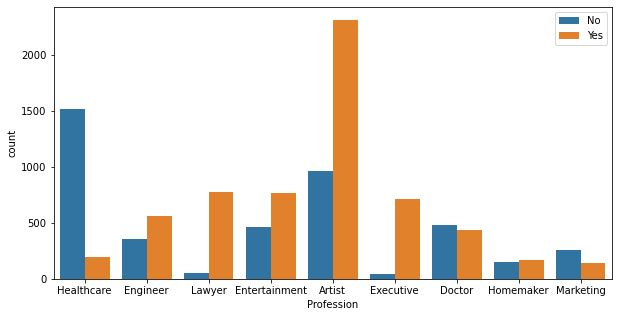

In [14]:
plt.figure(figsize = (10, 5))
plot_cat(1, 1, 1, 'Profession', 'Ever_Married', train)

## 1.3 空值填充

我们之前已经找到了存在有空值的项,现在对其进行处理

In [15]:
has_null = sorted(list(has_null)) #这个实际上不需要加,只是为了后面输出顺序固定比较好看.如果依然保持has_null为set数据格式不影响结果,但是后面打应的输出顺序在每次执行时不一定一样
print(has_null)

['Ever_Married', 'Family_Size', 'Graduated', 'Profession', 'Var_1', 'Work_Experience']


In [16]:
def print_null_rate(feature):
    cnt = len(train) - train[feature].count()
    rt = cnt/len(train)
    print("在数据中,{}一共有{}个缺失值,占总数量的{}%".format(feature, cnt, round(rt * 100, 2)))

In [17]:
for item in has_null:
    print_null_rate(item)

在数据中,Ever_Married一共有190个缺失值,占总数量的1.78%
在数据中,Family_Size一共有448个缺失值,占总数量的4.19%
在数据中,Graduated一共有102个缺失值,占总数量的0.95%
在数据中,Profession一共有162个缺失值,占总数量的1.51%
在数据中,Var_1一共有108个缺失值,占总数量的1.01%
在数据中,Work_Experience一共有1098个缺失值,占总数量的10.27%


缺失值最多的Work_Experience中只有10%数据丢失且为数值型变量, 所以所有缺失数据都可以采用填充方法,而不需要用有-无进行二分类处理或在特征中增加一个缺失项

In [18]:
has_null_cat = []
has_null_num = []
for item in has_null:
    if item in cat_vals:
        has_null_cat.append(item)
    else:
        has_null_num.append(item)
print(has_null_cat)
print(has_null_num)

['Ever_Married', 'Graduated', 'Profession', 'Var_1']
['Family_Size', 'Work_Experience']


使用函数统一处理缺失值

In [19]:
def fill_num(feature, dataset):
    # 使用中位数填充数值型变量
    dataset[feature].fillna(dataset[feature].median(), inplace = True)

In [20]:
def fill_cat(feature, dataset):
    # 使用众数填充离散变量
    dataset[feature].fillna(dataset[feature].mode()[0], inplace = True)

In [21]:
for dataset in [train, test]:
    for feature in has_null_num:
        fill_num(feature, dataset)
    for feature in has_null_cat:
        fill_cat(feature, dataset)

再次用info()检查一下train和test确保填充成功,使用describe查看保证填充的正确性

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           10695 non-null  object 
 1   Ever_Married     10695 non-null  object 
 2   Age              10695 non-null  int64  
 3   Graduated        10695 non-null  object 
 4   Profession       10695 non-null  object 
 5   Work_Experience  10695 non-null  float64
 6   Spending_Score   10695 non-null  object 
 7   Family_Size      10695 non-null  float64
 8   Var_1            10695 non-null  object 
 9   Segmentation     10695 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 835.7+ KB


In [23]:
train.describe(include = 'all')

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,10695,10695,10695.000000,10695,10695,10695.000000,10695,10695.000000,10695,10695
unique,2,2,NaN,2,9,NaN,3,NaN,7,4
top,Male,Yes,NaN,Yes,Artist,NaN,Low,NaN,Cat_6,D
freq,5841,6353,NaN,6672,3480,NaN,6494,NaN,7018,3027
mean,NaN,NaN,43.511828,NaN,NaN,2.453483,NaN,2.850584,NaN,NaN
std,NaN,NaN,16.774158,NaN,NaN,3.249413,NaN,1.504225,NaN,NaN
min,NaN,NaN,18.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
25%,NaN,NaN,30.000000,NaN,NaN,0.000000,NaN,2.000000,NaN,NaN
50%,NaN,NaN,41.000000,NaN,NaN,1.000000,NaN,3.000000,NaN,NaN
75%,NaN,NaN,53.000000,NaN,NaN,3.000000,NaN,4.000000,NaN,NaN


In [24]:
train_x = train.drop('Segmentation', axis = 1)

## 1.4 离散型变量转为可计算的数值

通过前面的可视化观察,除Spending_Score外其余变量之间似乎都没有明显的相关性

我们将Spending_Score做Order Encoding处理,其他使用Dummy Encoding处理

In [25]:
def replace_score(df):
    def mapping(x):
        if x == 'Low':
            return 0
        elif x == 'Average':
            return 1
        return 2
    df['Spending_Score'] = df['Spending_Score'].apply(lambda x: mapping(x))

In [26]:
replace_score(train_x)

In [27]:
def replace_cats(df):
    for feature in cat_vals:
        if feature != 'Spending_Score':
            dummy_features = pd.get_dummies(df[feature], drop_first=True)
            df = pd.concat([df, dummy_features], axis = 1)
            df.drop(feature, axis = 1, inplace = True)
    return df

In [28]:
train_x = replace_cats(train_x)

In [29]:
train_x.describe(include = 'all')

,Age,Work_Experience,Spending_Score,Family_Size,Male,Yes,Yes,Doctor,Engineer,Entertainment,...,Healthcare,Homemaker,Lawyer,Marketing,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7
count,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,...,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000
mean,43.511828,2.453483,0.542590,2.850584,0.546143,0.594016,0.623843,0.086957,0.087424,0.116877,...,0.163628,0.030669,0.078915,0.037681,0.052641,0.101823,0.137915,0.010659,0.656194,0.025152
std,16.774158,3.249413,0.740146,1.504225,0.497890,0.491104,0.484443,0.281785,0.282469,0.321289,...,0.369955,0.172426,0.269619,0.190433,0.223327,0.302430,0.344827,0.102696,0.474999,0.156594
min,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,53.000000,3.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,89.000000,14.000000,2.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1.5 线性相关性检查与标准化

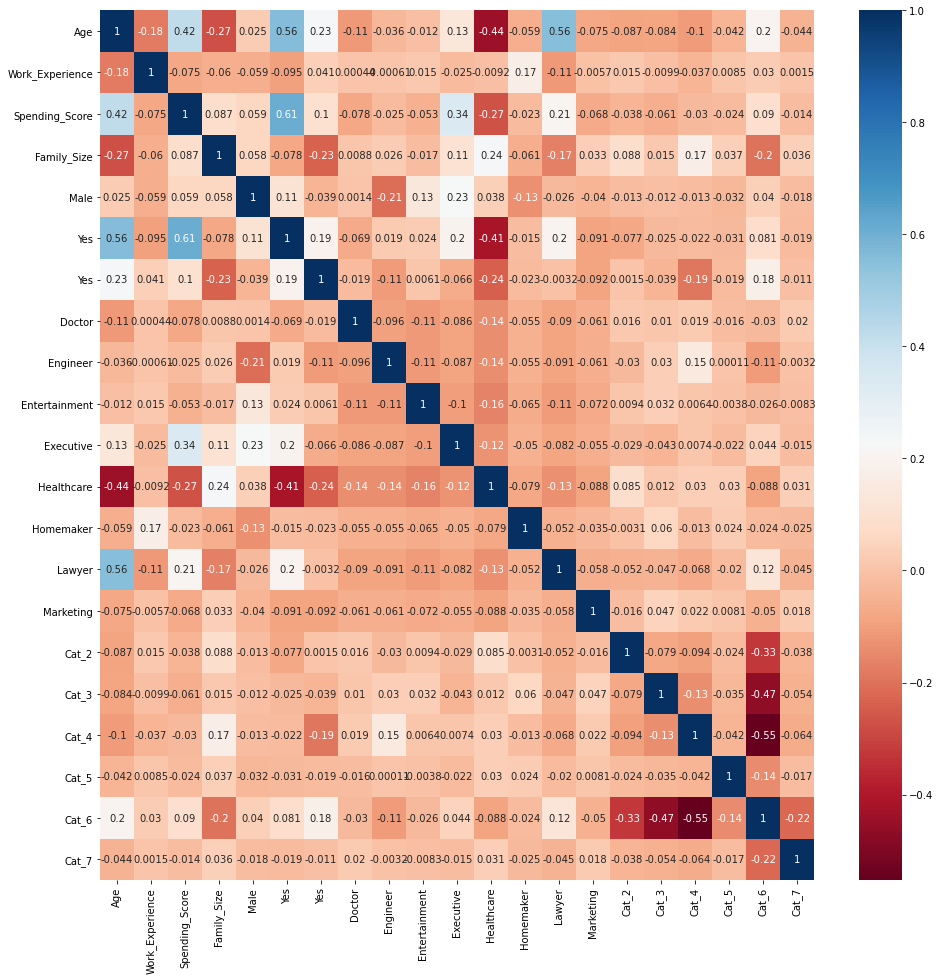

In [30]:
plt.figure(figsize=[16, 16])
sns.heatmap(train_x.corr(),annot=True, cmap = plt.cm.RdBu)
plt.show()

存在线性相关性高于0.6的变量(但为0.61), 存在并不是极为严重的共线性.

需要注意的是, 如果使用分类算法中的树类模型(如随机森林, XGB等), 预测结果不受多重共线性影响.但模型解释性会受影响. 所以在特征较少的情况下, 还是需要人工剔除相关系数过高的两项的其中之一.

分类算法中的逻辑回归和线性回归受多重共线性影响较大(共线性会导致冗余, 减小模型泛化能力, 也就是说会导致过拟合), 当数据极多且拥有多重共线性, 难以分析剔除时, 如果必须使用回归算法, 那么应采用岭回归或使用PCA(主成分分析)去除多重共线性(模型可解释性也会降低, 但是当数据有成百上千个维度时,通常也不需要解释)

聚类算法也受多重共线性影响,与线性回归一样, 需要使用分析剔除/使用PCA降维的手段去除多重共线性

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x_standard = scaler.fit_transform(train_x)

## 1.6 PCA降维并降低共线性

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
train_pca = pca.fit_transform(train_x_standard)

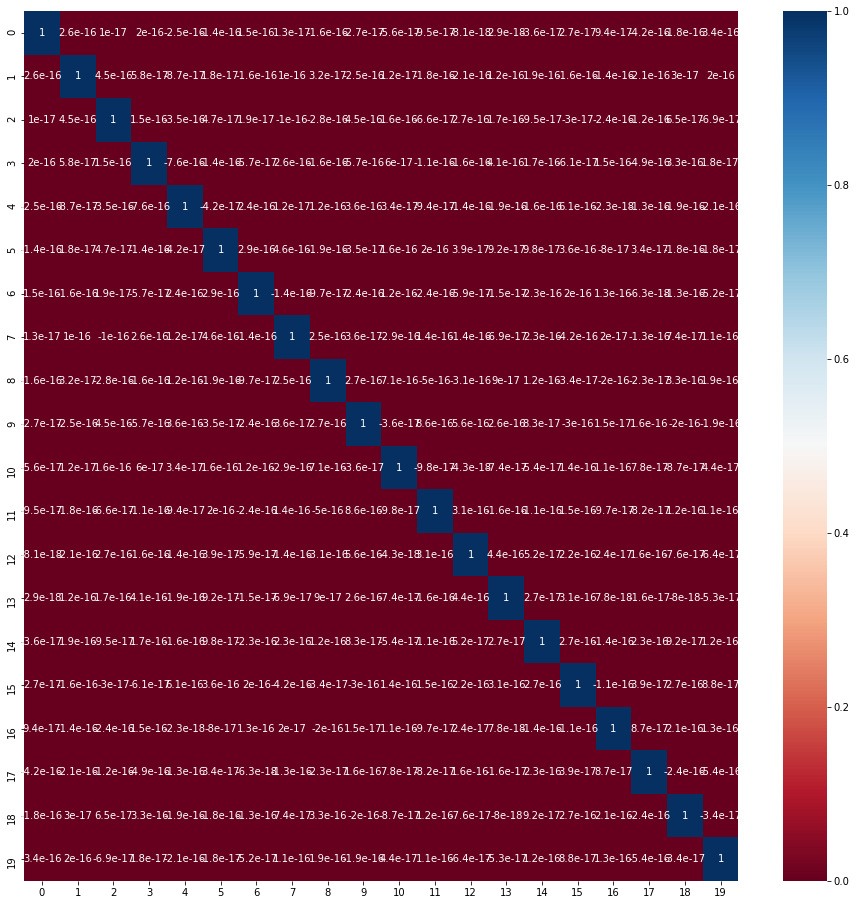

In [33]:
all_data = pd.DataFrame(train_pca)
plt.figure(figsize=[16, 16])
sns.heatmap(all_data.corr(),annot=True, cmap = plt.cm.RdBu)
plt.show()

# 2. 使用Kmeans建模

在数据中我们已经知道目标产品数量为4了,也就是说聚类的n_cluster已经明确,那么我们可以用kmeans实现

In [34]:
from sklearn.cluster import KMeans

In [35]:
estimator = KMeans(n_clusters=4)
ans = estimator.fit(train_pca).labels_
train['cluster_kmean'] = ans

In [36]:
train['cluster_kmean'].value_counts()

3    5377
0    2794
2    1682
1     842
Name: cluster_kmean, dtype: int64

In [37]:
train['Segmentation'].value_counts()

D    3027
A    2818
C    2442
B    2408
Name: Segmentation, dtype: int64

# 3. 层次聚类

在不知道n_clusters数量时,可以采用层次聚类方法.但层次聚类同样可以定义该参数.

在知道n_clusters数量且解空间是以中心点为半径扩展时,推荐采用kmeans.层次聚类存在速度过慢的问题, 但可以聚类非凸或不知道目标聚类个数的数据

In [38]:
from sklearn.cluster import AgglomerativeClustering

In [39]:
estimator = AgglomerativeClustering()
ans = estimator.fit(train_pca).labels_
train['cluster_hier'] = ans

In [40]:
train['cluster_hier'].value_counts()

0    5675
1    5020
Name: cluster_hier, dtype: int64

In [41]:
train['Segmentation'].value_counts()

D    3027
A    2818
C    2442
B    2408
Name: Segmentation, dtype: int64

# 4. 结果可视化分析

由之前的数据可视化得知, Work_Experience和Family_Size这两个数值型变量的唯一项很少,可以当成离散型变量进行可视化处理

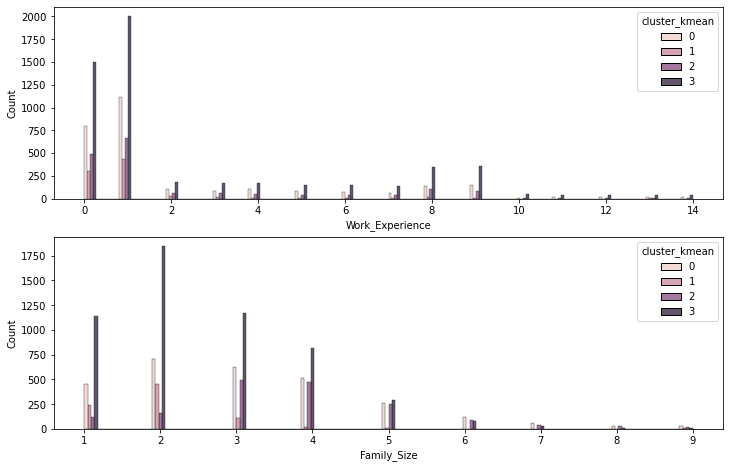

In [42]:
to_plot = ['Work_Experience', 'Family_Size']
plt.figure(figsize=[12,12])
for i in range(len(to_plot)):
    batch_num_plotting(3, 1, i + 1, x = to_plot[i], hue = 'cluster_kmean', data = train)

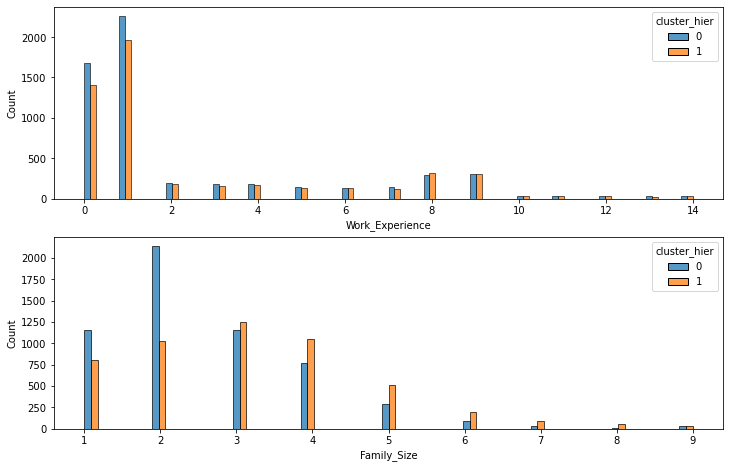

In [43]:
plt.figure(figsize=[12,12])
for i in range(len(to_plot)):
    batch_num_plotting(3, 1, i + 1, x = to_plot[i], hue = 'cluster_hier', data = train)

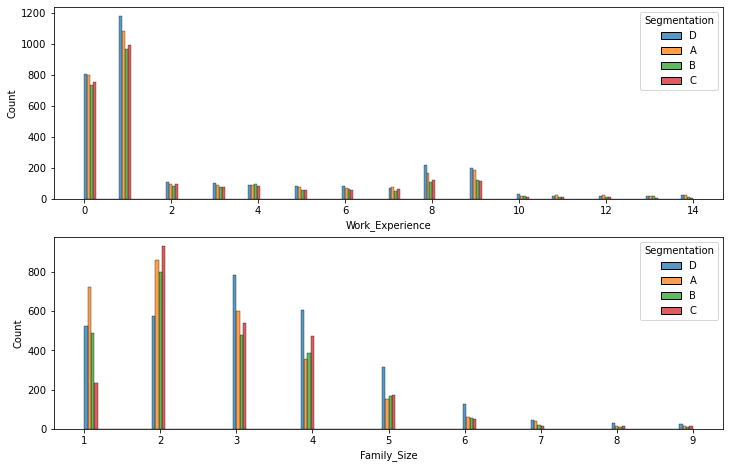

In [44]:
plt.figure(figsize=[12,12])
for i in range(len(to_plot)):
    batch_num_plotting(3, 1, i + 1, x = to_plot[i], hue = 'Segmentation', data = train)

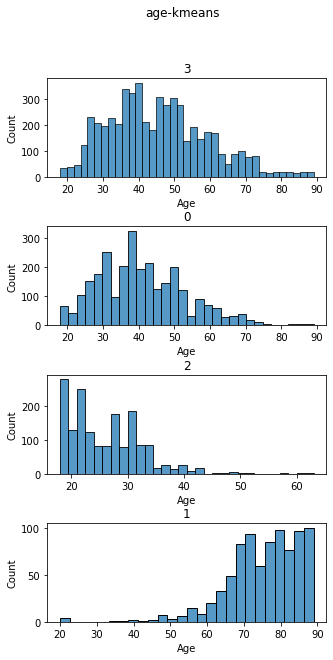

In [45]:
plt.figure(figsize=[5,10])
plt.subplots_adjust(wspace = 0, hspace = 0.5)
plot_age('cluster_kmean', train)
plt.suptitle('age-kmeans')
plt.show()

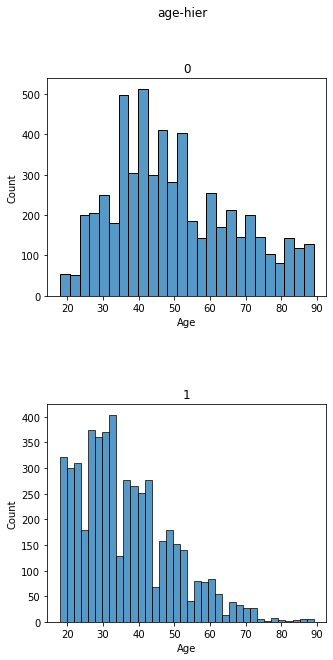

In [46]:
plt.figure(figsize=[5,10])
plt.subplots_adjust(wspace = 0, hspace = 0.5)
plot_age('cluster_hier', train)
plt.suptitle('age-hier')
plt.show()

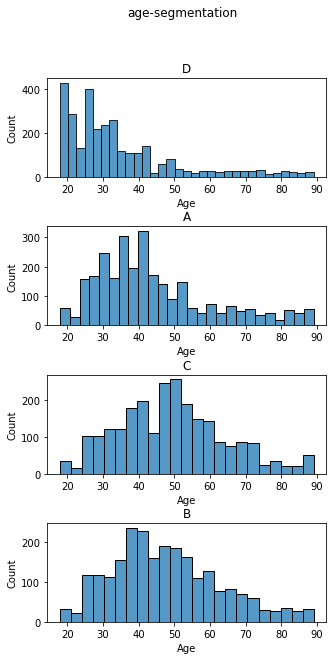

In [47]:
plt.figure(figsize=[5,10])
plt.subplots_adjust(wspace =0, hspace = 0.5)
plot_age('Segmentation', train)
plt.suptitle('age-segmentation')
plt.show()

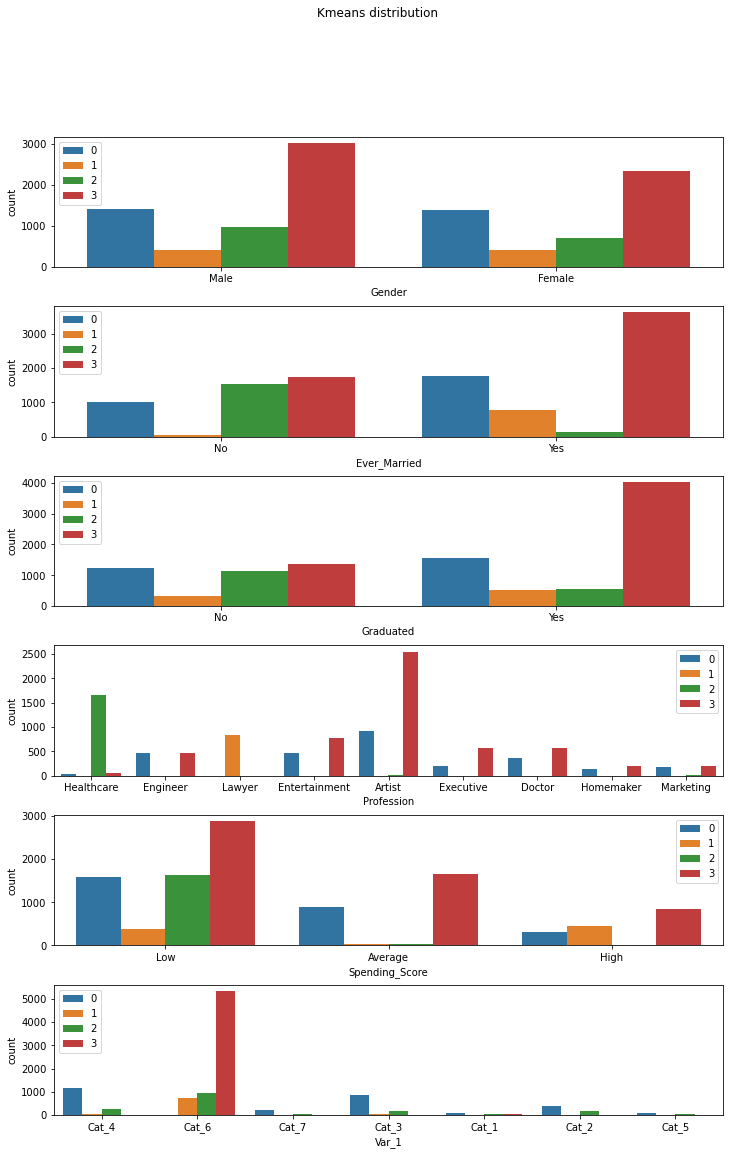

In [52]:
l = len(cat_vals)
plt.figure(figsize=[12,3 * l])
plt.suptitle('Kmeans distribution')
plt.subplots_adjust(wspace =0, hspace = 0.3)
for i in range(len(cat_vals)):
    plot_cat(l, 1, i + 1, cat_vals[i], 'cluster_kmean', train)
plt.show()


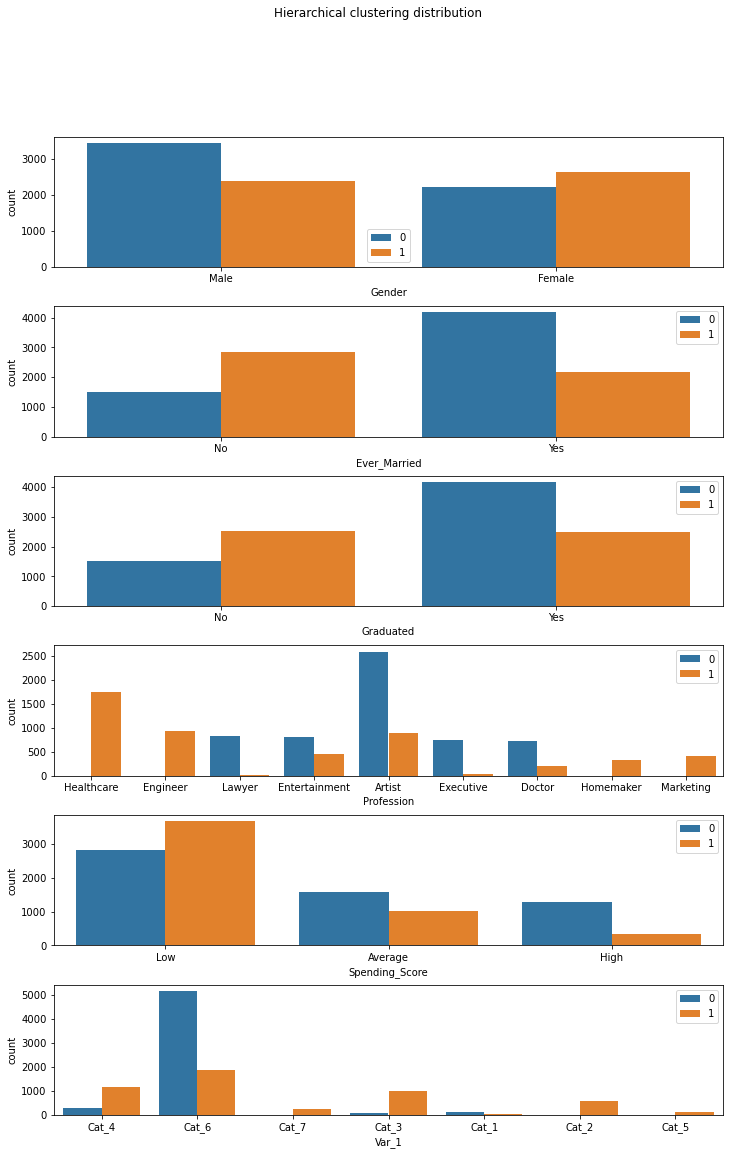

In [49]:
plt.figure(figsize=[12,3 * l])
plt.subplots_adjust(wspace =0, hspace = 0.3)
for i in range(len(cat_vals)):
    plot_cat(l, 1, i + 1, cat_vals[i], 'cluster_hier', train)
plt.suptitle('Hierarchical clustering distribution')
plt.show()

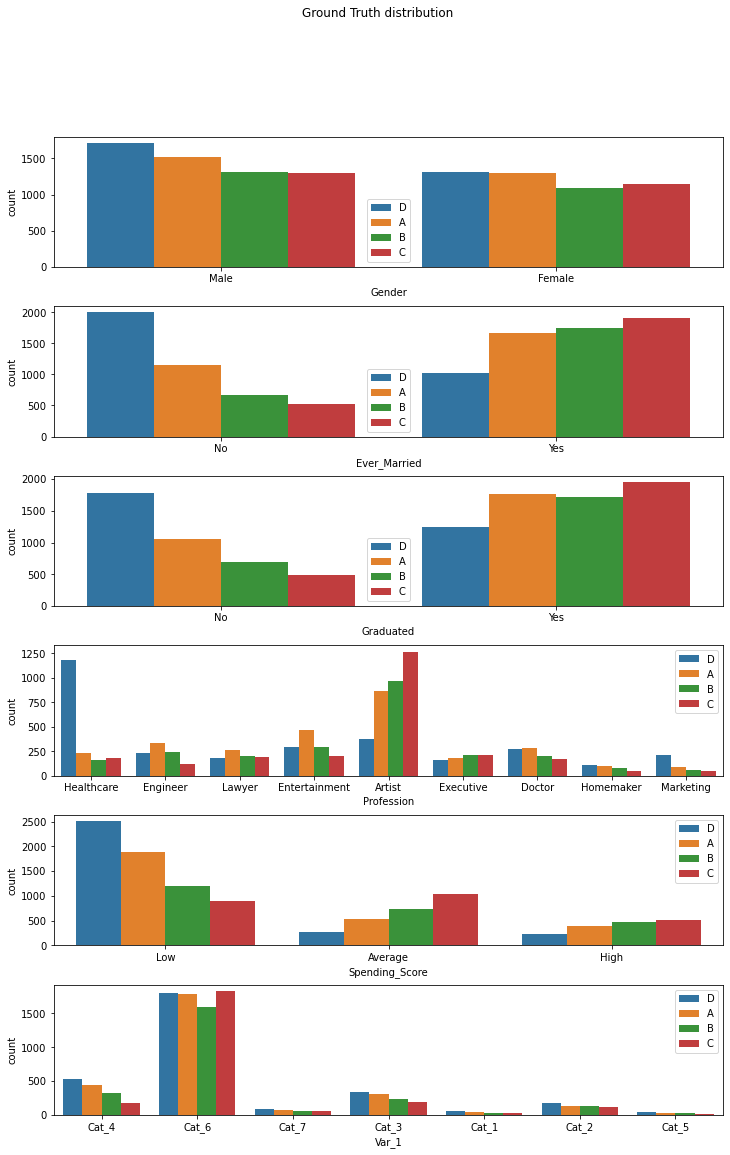

In [50]:
plt.figure(figsize=[12,3 * l])
plt.subplots_adjust(wspace =0, hspace = 0.3)
for i in range(len(cat_vals)):
    plot_cat(l, 1, i + 1, cat_vals[i], 'Segmentation', train)
plt.suptitle('Ground Truth distribution')
plt.show()

思考: 为何真实结果与预测的人群数据分布差距如此大?

聚类更适用于没有用户基础的新品的推广. 对于已有大量用户的产品, 如果没有明显的人群偏向(比如A产品的特征1数值较大, B产品的特征1数值较小等), 采用分类算法的准确度更高

并且我们在这里使用了正规化操作,这意味着将所有的特征权重视为等同.在实际过程中,需要根据实际业务情况对特征进行适当的缩放,删减后再进行聚类